In [2]:
!nvidia-smi

Fri Jul  9 17:45:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Load custom package from Github**



In [3]:
!git clone https://github.com/Gilf641/torchly

from google.colab import files
import sys
import os
os.chdir('torchly')
ROOT_DIR = '/content'
# /content/torchly
# To find local version of the library
sys.path.append(os.path.join(ROOT_DIR, 'torchly'))  


Cloning into 'torchly'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 138 (delta 55), reused 116 (delta 33), pack-reused 0
Receiving objects: 100% (138/138), 108.80 KiB | 920.00 KiB/s, done.
Resolving deltas: 100% (55/55), done.


In [4]:
import sys
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
sys.path.append('/content/gdrive/MyDrive')

%reload_ext tensorboard


Mounted at /content/gdrive


In [5]:
!pip install -U albumentations>=0.3.0 --user
!pip install --upgrade git+https://github.com/albumentations-team/albumentations


import albumentations as A

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-iaok9gxk
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-iaok9gxk
  Created wheel for albumentations: filename=albumentations-1.0.2-cp37-none-any.whl size=98523 sha256=9cc9f9170c5ae2fa56da04d8612f15178dbf6c36b14c919f9f33a90a4aa82071
  Stored in directory: /tmp/pip-ephem-wheel-cache-is3d9uuu/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: albumentations 1.0.2
    Uninstalling albumentations-1.0.2:
      Successfully uninstalled albumentations-1.0.2


**Load required packages**

In [7]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict

# custom torch package
import torchly
from torchly.run import train, test, fit, lr_finder
from torchly.data.gradcam import generate_gcam, unnormalize, plot_gcam 
from torchly.data.dataloader import convert
from torchly.data.dataset import CIFAR_Dataset
from torchly.utils import data_utils, model_utils
from torchly.models.custom_models import CustomResNet
from torchly.models.resnet import ResNet18
from torchly.torchsummary import summary
from torchly.run.runner2 import run, get_class_accuracy


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [8]:
# Download CIFAR data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Train and Test Transforms**


In [9]:

train_transform = A.Compose(
    [
        A.Normalize(mean=(0.4675, 0.4599, 0.4236), std=(0.2901, 0.2874, 0.2917)),
        A.PadIfNeeded(min_height=36, min_width=36, p=0.5),
        A.RandomCrop(height=32, width=32, always_apply=True),
        # A.Cutout(),
        A.Flip(p=0.5),
        # A.Rotate(limit=(-5,5)),
        A.CoarseDropout(max_holes = 1, max_height=8, max_width=8, min_holes = 1, min_height=8, min_width=8, fill_value=(0.4675, 0.4599, 0.4236), mask_fill_value = None),
        ToTensorV2(),
    ])


test_transform = A.Compose(
    [
        A.Normalize(mean=(0.4675, 0.4599, 0.4236), std=(0.2901, 0.2874, 0.2917)),
        ToTensorV2(),
    ])

In [10]:
train = CIFAR_Dataset(trainset.data, trainset.targets, transforms=train_transform)
test = CIFAR_Dataset(testset.data, testset.targets, transforms=test_transform)

train_loader, test_loader = convert(train, test, batch_size=512)


**Setting up Config**

In [12]:
class GlobalConfig:
    seed = 1992
    num_classes = 10
    batch_size = 512
    EPOCHS = 24
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # data
    input_image_size = (3, 32, 32)
    mean = (0.4675, 0.4599, 0.4236)
    std_dev = (0.2901, 0.2874, 0.2917)
    trainloader = train_loader
    testloader = test_loader

    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



    # model data normalization
    channel_norm = 'BatchNorm2d'
    channel_norm_params = {'GroupNorm': {'num_groups':1}, # doing layernorm here
                 'BatchNorm2d':{'affine':True}}
                #  'LayerNorm': {'normalized_shape':10}}
                

    # regularizer
    dropout_value = 0.00

    # loss
    # loss_function = 'CrossEntropyLoss'
    loss_function = 'NLLLoss'

    # scheduler
    lr_scheduler = 'OneCycleLR'
    lr_scheduler_params = {'StepLR': {'step_size':7, 'gamma':0.5},
                
                'ReduceLROnPlateau': {'mode':'min', 'factor':0.5, 'patience':2, 'threshold':0.0001,
                                      'threshold_mode':'rel', 'cooldown':0, 'min_lr':1e-4,
                                      'eps':1e-08, 'verbose':True},
                'OneCycleLR': {'max_lr': 0.05, 'steps_per_epoch':len(trainloader), 'div_factor':20, 'epochs':EPOCHS }}
                                

    # optimizer
    optimizer = 'SGD'
    optimizer_params = {'SGD':{'lr':0.01, 'momentum':0.9}}

    # store model stats
    model_results = {'TestAccuracy': [], 
                  'TrainAccuracy': [],
                  'TestLoss': [],
                  'TrainLoss':[]}

    # Params
    misclassified=True
    L1Lambda=False

    # ModelName
    name='168K_100Epochs'

    
modelconfig = GlobalConfig


Let us show some of the training images, for fun.



**Data Visualization**

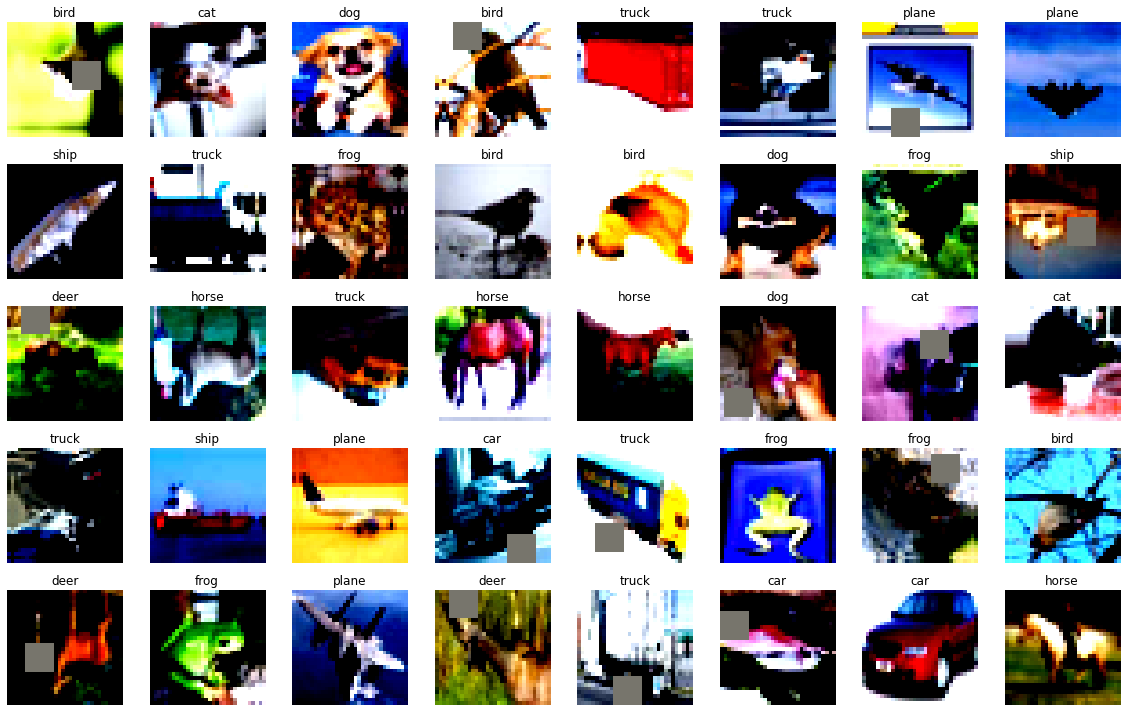

In [13]:
img, label = next(iter(modelconfig.trainloader))
data = CIFAR_Dataset(img,label)
data_utils.plot_data(data,modelconfig)

All classes have same number of images, 5000. Dataset is balanced. 

**Model Summary**

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomResNet1(nn.Module):
  def __init__(self, config):
    super(CustomResNet, self).__init__()
    self.config = config
    self.prep_layer = nn.Sequential(
                                nn.Conv2d(3,64, 3,stride=1,padding=1), 
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.Dropout(self.config.dropout_value)
        )
    self.layer1x = self.xconv(64, 128)
    self.layer1res = self.resblock(64, 128, self.layer1x)

    self.layer2x = self.xconv(128, 256)

    self.layer3x = self.xconv(256, 512)
    self.layer3res = self.resblock(256, 512, self.layer3x)

    self.gap = nn.AdaptiveAvgPool2d(1)
    self.last_but_one_conv = nn.Conv2d(512, 256, 1)
    self.last_conv = nn.Conv2d(256, 10,1)
  
  def xconv(self, in_ch, out_ch):
    self._layer = nn.Sequential(
                                nn.Conv2d(in_ch,out_ch, 3,stride=1,padding=1), 
                                nn.MaxPool2d(4,stride=2),
                                nn.BatchNorm2d(out_ch),
                                nn.ReLU(),
                                nn.Dropout(self.config.dropout_value)
        )
    # print(dir(self._layer))
    return self._layer
    
  def resblock(self, in_ch, out_ch,  x_layer):
    self.block = nn.Sequential(
                                nn.Conv2d(in_ch,out_ch, 3, stride=1), 
                                nn.BatchNorm2d(out_ch),
                                nn.ReLU(),
                                nn.Dropout(self.config.dropout_value),
                                nn.Conv2d(out_ch,out_ch, 2, stride=2), 
                                nn.BatchNorm2d(out_ch),
                                nn.ReLU(),
                                nn.Dropout(self.config.dropout_value)
        )
    self_resblock = self.block
    return self_resblock

  def forward(self, input):
    prep_op = self.prep_layer(input) 
    # print("prep_op shape", prep_op.shape)   

    layer1x = self.layer1x(prep_op)
    # print("layer1x shape", layer1x.shape)   
    layer1res = self.layer1res(prep_op)
    # print("layer1res shape", layer1res.shape)   
    resblock_layer1 = layer1x + layer1res
    # print("resblock_layer1 shape", resblock_layer1.shape)   
    layer1_op = layer1x+layer1res
    # print("layer1_op shape", layer1_op.shape)   

    layer2op = self.layer2x(layer1_op)
    # print("layer2op shape", layer2op.shape)   


    layer3x = self.layer3x(layer2op)
    # print("layer3x shape", layer3x.shape)   
    layer3res = self.layer3res(layer2op)
    # print("layer3res shape", layer3res.shape)   
    resblock_layer3 = layer3x + layer3res
    # print("resblock_layer3 shape", resblock_layer3.shape)   
    layer3_op = layer3x+layer3res
    # print("layer3_op shape", layer3_op.shape)  
    
    gap = self.gap(layer3_op)

    last_but_one = self.last_but_one_conv(gap)
    last_one = self.last_conv(last_but_one)
   
    final_op = last_one.view(last_one.shape[0],-1)


    if self.config.loss_function == 'CrossEntropyLoss':
      return final_op
    elif self.config.loss_function == 'NLLLoss':
      return F.log_softmax(final_op, dim=-1)



In [16]:
model = CustomResNet(modelconfig).to(modelconfig.device)
summary(model, (3,32,32))

------------------------------------------------------------------------------------------------
        Layer (type)               Output Shape         Param #           Receptive Field
            Conv2d-1           [-1, 64, 32, 32]           1,792               3
       BatchNorm2d-2           [-1, 64, 32, 32]             128               3
              ReLU-3           [-1, 64, 32, 32]               0               3
           Dropout-4           [-1, 64, 32, 32]               0               3
            Conv2d-5          [-1, 128, 32, 32]          73,856               5
         MaxPool2d-6          [-1, 128, 15, 15]               0               8
       BatchNorm2d-7          [-1, 128, 15, 15]             256               8
              ReLU-8          [-1, 128, 15, 15]               0               8
           Dropout-9          [-1, 128, 15, 15]               0               8
           Conv2d-10          [-1, 128, 30, 30]          73,856              12
      BatchNo

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(tensor(4058122), tensor(4058122))

The loss has diverged, Stopping Early!


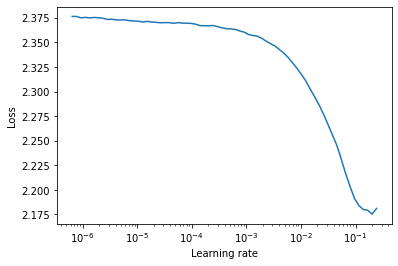

In [17]:
criterion = getattr(torch.nn, modelconfig.loss_function)()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder_obj = lr_finder.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder_obj.range_test(modelconfig.trainloader, end_lr=10, num_iter=100, step_mode="exp")
lr_finder_obj.plot()

**Run the model**

In [ ]:
model =  CustomResNet(modelconfig).to(modelconfig.device)
result_dict, test_misc_images = run(model, modelconfig)

  0%|          | 0/98 [00:00<?, ?it/s]

==========RUNNING THE MODEL==========

EPOCH 1 | LR [0.008000000000000007]: 


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Train set: Loss=1.1813740730285645 Batch_id=97 Accuracy=44.47: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]



Test set: Loss: 1.2596, Accuracy: 5389/10000 (53.89%)



  0%|          | 0/98 [00:00<?, ?it/s]


EPOCH 2 | LR [0.01701959344058193]: 


Train set: Loss=0.9698836207389832 Batch_id=97 Accuracy=60.93: 100%|██████████| 98/98 [00:29<00:00,  3.33it/s]



Test set: Loss: 1.0325, Accuracy: 6369/10000 (63.69%)



  0%|          | 0/98 [00:00<?, ?it/s]


EPOCH 3 | LR [0.04238351822413211]: 


Train set: Loss=0.9055997729301453 Batch_id=97 Accuracy=67.05: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]



Test set: Loss: 0.8590, Accuracy: 7054/10000 (70.54%)



  0%|          | 0/98 [00:00<?, ?it/s]


EPOCH 4 | LR [0.0793256849838772]: 


Train set: Loss=0.8175519108772278 Batch_id=97 Accuracy=71.50: 100%|██████████| 98/98 [00:28<00:00,  3.40it/s]



Test set: Loss: 0.8270, Accuracy: 7038/10000 (70.38%)



  0%|          | 0/98 [00:00<?, ?it/s]


EPOCH 5 | LR [0.12090435778258629]: 


Train set: Loss=0.6484935283660889 Batch_id=97 Accuracy=74.46: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]



Test set: Loss: 0.7694, Accuracy: 7306/10000 (73.06%)



  0%|          | 0/98 [00:00<?, ?it/s]


EPOCH 6 | LR [0.15930656319435654]: 


Train set: Loss=0.5993459820747375 Batch_id=97 Accuracy=76.41: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Loss: 0.6661, Accuracy: 7629/10000 (76.29%)



  0%|          | 0/98 [00:00<?, ?it/s]


EPOCH 7 | LR [0.18731621205177368]: 


Train set: Loss=0.6178377866744995 Batch_id=97 Accuracy=78.50: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Loss: 0.6612, Accuracy: 7640/10000 (76.40%)



  0%|          | 0/98 [00:00<?, ?it/s]


EPOCH 8 | LR [0.19967006174843435]: 


Train set: Loss=0.5673384666442871 Batch_id=97 Accuracy=79.95: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]



Test set: Loss: 0.6455, Accuracy: 7786/10000 (77.86%)



  0%|          | 0/98 [00:00<?, ?it/s]


EPOCH 9 | LR [0.19885446757063494]: 


Train set: Loss=0.5219225883483887 Batch_id=97 Accuracy=81.56: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]



Test set: Loss: 0.6480, Accuracy: 7807/10000 (78.07%)



  0%|          | 0/98 [00:00<?, ?it/s]


EPOCH 10 | LR [0.1943251614413558]: 


Train set: Loss=0.5747846961021423 Batch_id=97 Accuracy=82.61: 100%|██████████| 98/98 [00:29<00:00,  3.35it/s]



Test set: Loss: 0.6578, Accuracy: 7817/10000 (78.17%)



Train set: Loss=0.41795775294303894 Batch_id=97 Accuracy=83.50: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]



Test set: Loss: 0.5751, Accuracy: 8057/10000 (80.57%)



  0%|          | 0/98 [00:00<?, ?it/s]


EPOCH 12 | LR [0.1756726649118383]: 


Train set: Loss=0.48822930455207825 Batch_id=97 Accuracy=84.35: 100%|██████████| 98/98 [00:29<00:00,  3.36it/s]



Test set: Loss: 0.5375, Accuracy: 8179/10000 (81.79%)



  0%|          | 0/98 [00:00<?, ?it/s]


EPOCH 13 | LR [0.16219983210662656]: 


Train set: Loss=0.4414222836494446 Batch_id=48 Accuracy=85.65:  50%|█████     | 49/98 [00:14<00:14,  3.40it/s]

**Misclassified Images**

In [ ]:
len(test_misc_images)

0

In [ ]:

test_misc_images = [test_misc_images[i] for i in range(20)]
data_utils.plot_misclassified_rgb(test_misc_images, 'test_misc_batchnorm.png',plot_size=(20,12), config=modelconfig)

IndexError: ignored

**GradCam**

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


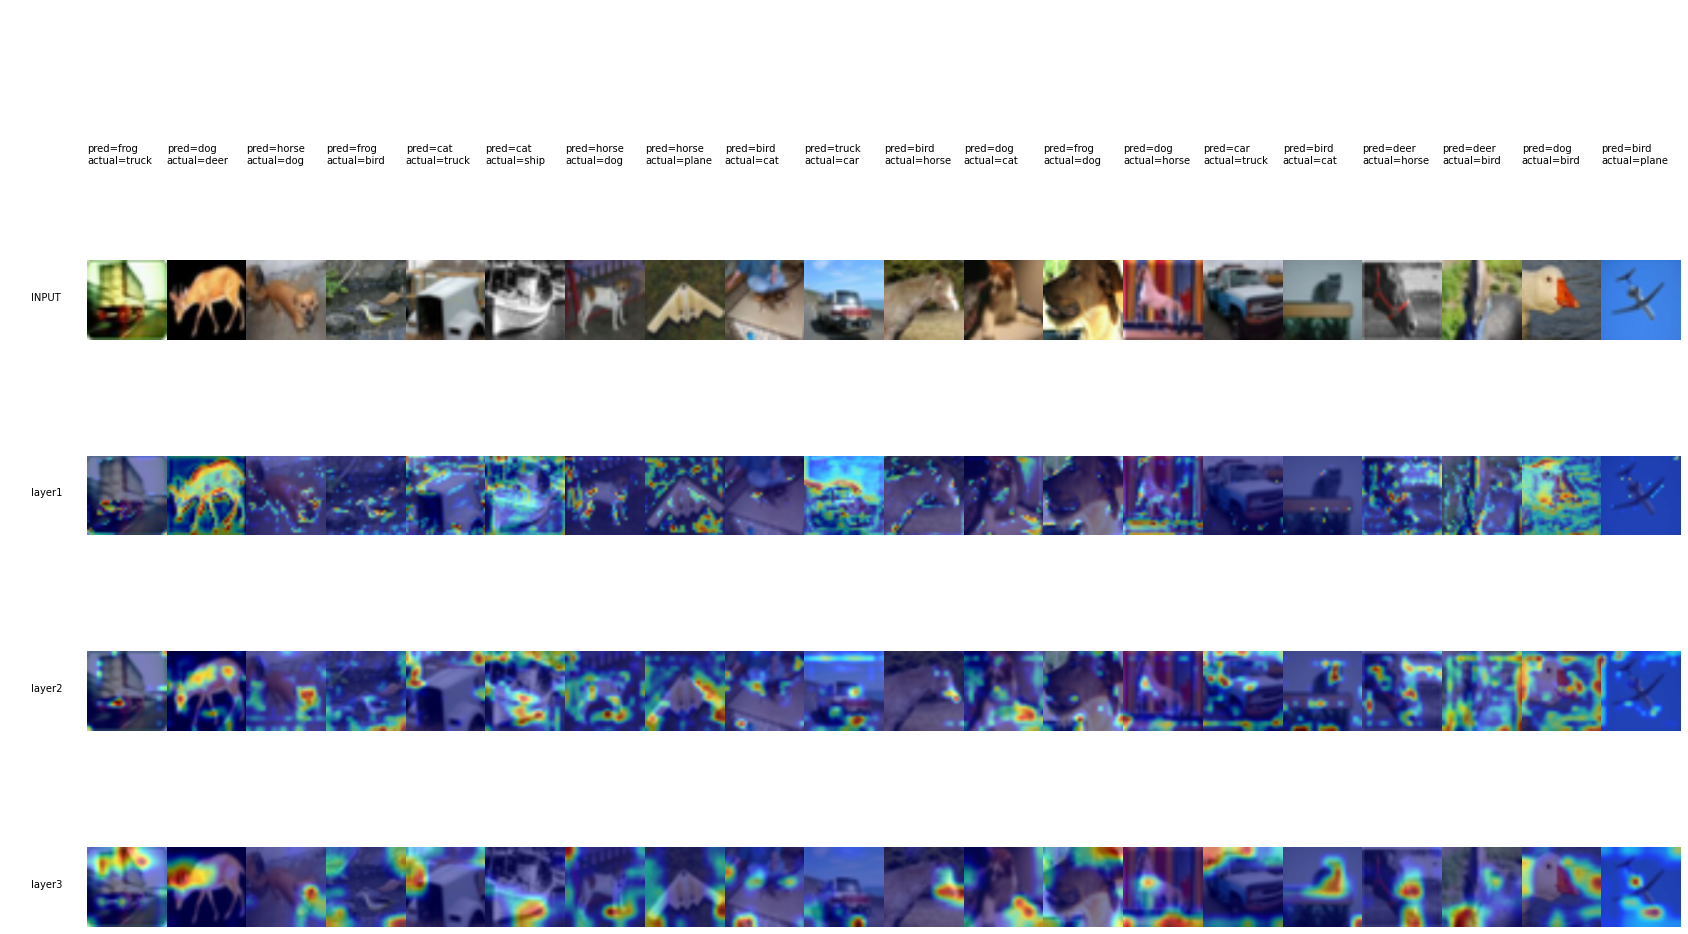

In [ ]:
# model = ResNet18(mod).to(device)
image_size = (3,32,32)
device = modelconfig.device
target_layers = ["layer1", "layer2", "layer3"]#, "layer4"]

images = [x['image'] for x in test_misc_images]
target_classes = [l['label'] for l in test_misc_images]
gradcam_layers, probs, predicted_classes = generate_gcam(images, device, target_classes, model, target_layers)

plot_gcam(modelconfig, gradcam_layers, images, target_classes, target_layers, modelconfig.classes, image_size, predicted_classes)


In [ ]:

get_class_accuracy(model, modelconfig)

Accuracy of plane : 72 %
Accuracy of   car : 90 %
Accuracy of  bird : 74 %
Accuracy of   cat : 74 %
Accuracy of  deer : 89 %
Accuracy of   dog : 75 %
Accuracy of  frog : 96 %
Accuracy of horse : 85 %
Accuracy of  ship : 96 %
Accuracy of truck : 79 %


In [ ]:
testacc = result_dict['TestAcc']
trainacc = result_dict['TrainAcc']
testloss = result_dict['TestLoss']
trainloss = result_dict['TrainLoss']
 

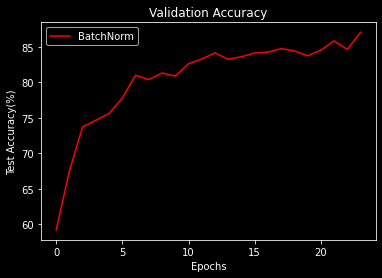

In [ ]:
data_utils.plot_curve(testacc, "Test Accuracy(%)")

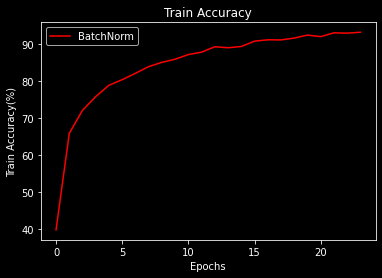

In [ ]:
data_utils.plot_curve(trainacc, "Train Accuracy(%)")

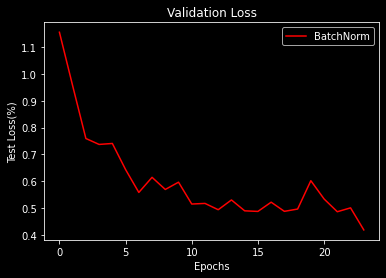

In [ ]:
data_utils.plot_curve(testloss, "Test Loss(%)")

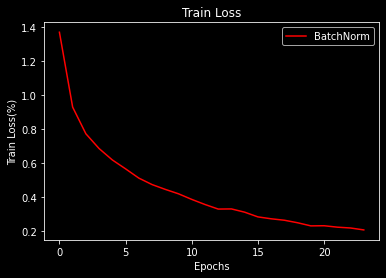

In [ ]:
data_utils.plot_curve(trainloss, "Train Loss(%)")